<a href="https://colab.research.google.com/github/ccseibell/LoRA_complexity/blob/main/LoRA_matrix_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-16-866293861bc7>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lora_params = torch.load(file_path, map_location="cpu")


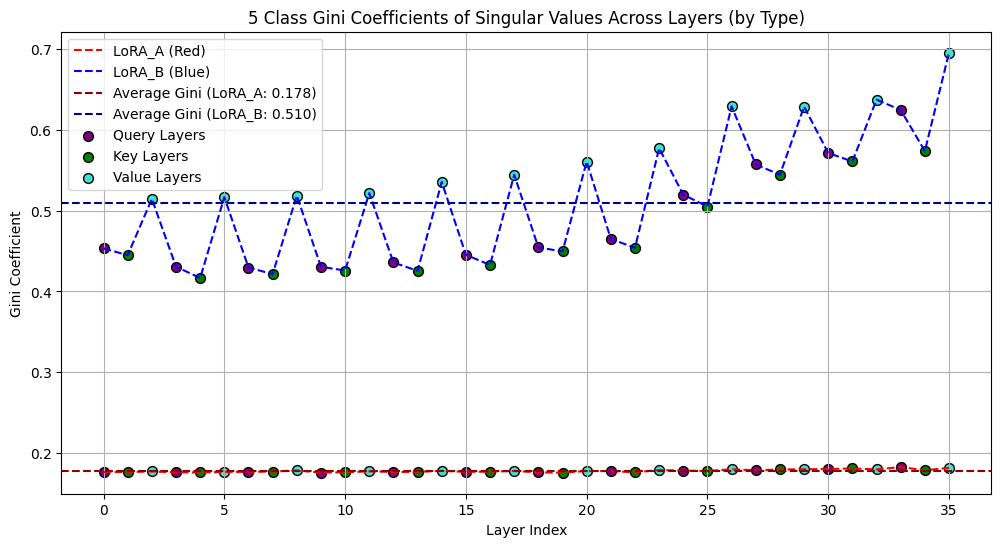

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# File path for the LoRA parameter file (.pt files)
file_path = "/content/lora_params_256_5class.pt"

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)  # Ensure non-negative values
    array += 1e-10  # Avoid division by zero
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    return (np.sum((2 * index - array.size - 1) * array)) / (array.size * np.sum(array))

# Load LoRA parameters
try:
    lora_params = torch.load(file_path, map_location="cpu")
except Exception as e:
    print(f"Error loading file {file_path}: {e}")
    raise

# Separate Gini coefficients and layer types
gini_coefficients_a = []
gini_coefficients_b = []
layer_types_a = []  # Store types (query, key, value) for LoRA_A
layer_types_b = []  # Store types (query, key, value) for LoRA_B

# Process each parameter
for name, matrix in lora_params.items():
    if isinstance(matrix, torch.Tensor):  # Ensure it's a tensor
        matrix_np = matrix.cpu().detach().numpy()
        try:
            # Perform SVD to get singular values
            singular_values = np.linalg.svd(matrix_np, compute_uv=False)

            # Determine if it's LoRA_A or LoRA_B
            if "lora_A" in name:
                gini_coefficients_a.append(gini(singular_values))
                if "query" in name:
                    layer_types_a.append("query")
                elif "key" in name:
                    layer_types_a.append("key")
                elif "value" in name:
                    layer_types_a.append("value")
            elif "lora_B" in name:
                gini_coefficients_b.append(gini(singular_values))
                if "query" in name:
                    layer_types_b.append("query")
                elif "key" in name:
                    layer_types_b.append("key")
                elif "value" in name:
                    layer_types_b.append("value")
        except np.linalg.LinAlgError as svd_error:
            print(f"SVD failed for layer {name}: {svd_error}")
        except Exception as e:
            print(f"Unexpected error processing layer {name}: {e}")

# Map layer types to colors
color_map = {"query": "purple", "key": "green", "value": "turquoise"}
dot_colors_a = [color_map[layer] for layer in layer_types_a]
dot_colors_b = [color_map[layer] for layer in layer_types_b]

# Plotting
plt.figure(figsize=(12, 6))

# Plot LoRA_A (red line) with color-coded dots
plt.plot(range(len(gini_coefficients_a)), gini_coefficients_a, color="red", linestyle="--", label="LoRA_A (Red)")
for i, color in enumerate(dot_colors_a):
    plt.scatter(i, gini_coefficients_a[i], color=color, edgecolor="black", s=50)

# Plot LoRA_B (blue line) with color-coded dots
plt.plot(range(len(gini_coefficients_b)), gini_coefficients_b, color="blue", linestyle="--", label="LoRA_B (Blue)")
for i, color in enumerate(dot_colors_b):
    plt.scatter(i, gini_coefficients_b[i], color=color, edgecolor="black", s=50)

# Add average lines
average_score_a = np.mean(gini_coefficients_a) if gini_coefficients_a else 0
average_score_b = np.mean(gini_coefficients_b) if gini_coefficients_b else 0
plt.axhline(y=average_score_a, color="darkred", linestyle="--", label=f"Average Gini (LoRA_A: {average_score_a:.3f})")
plt.axhline(y=average_score_b, color="darkblue", linestyle="--", label=f"Average Gini (LoRA_B: {average_score_b:.3f})")

# Add legend for colors
plt.scatter([], [], color="purple", edgecolor="black", s=50, label="Query Layers")
plt.scatter([], [], color="green", edgecolor="black", s=50, label="Key Layers")
plt.scatter([], [], color="turquoise", edgecolor="black", s=50, label="Value Layers")

# Labels, legend, and grid
plt.xlabel("Layer Index")
plt.ylabel("Gini Coefficient")
plt.title("5 Class Gini Coefficients of Singular Values Across Layers (by Type)")
plt.legend()
plt.grid(True)
plt.show()


2 Class
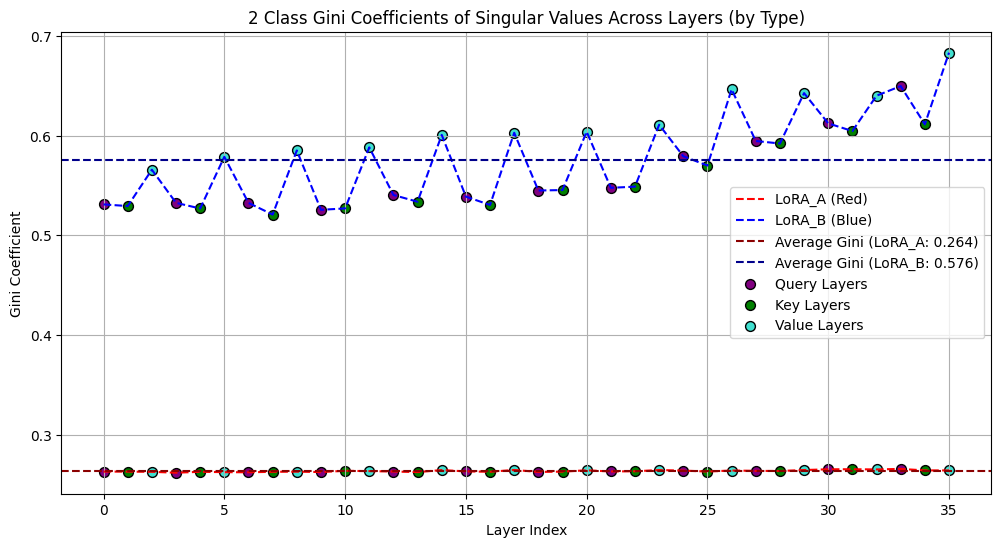